In [2]:
import numpy as np
import parser
import pandas as pd
import sys
import random
# chunksize = 10 ** 8
# for chunk in pd.read_csv('1mb.txt', chunksize=chunksize,delimiter=' '):
#     process(chunk)
# files=['1mb_short.txt','5mb_short.txt','10mb_short.txt','50mb_short.txt','100mb_short.txt']
# file='10mb_0.9_short.txt'    
# data=pd.read_csv(file,delimiter=' ')
# data.head()
# X = data.as_matrix()
# print(X)
# print(np.shape(X))

In [19]:
# len(set(X[:,1]))

In [20]:
###########Parameters###########################
# props={}
# writes=[0,0]
# reads=[0,0]
# num_writes=[0,0]
# num_reads=[0,0]
# avgtime=0
# storequeue=[[],[]]
# pending=[[],[]]
# updatedids=[]
# rank=np.ones((2,1))
# thr=[0,0]
# satisqueue=[]
# dramchan=8
# nvmchan=8
# delta=500
# num_chan=32
# currsize=[0,0]
# size=[256000000,2000000000]
# chan=np.ones((2,num_chan))
# miss=0
chanstats=np.zeros((2,num_chan))
#PerRankPerBank Policy Implemented
#Store 0:DRAM, 1:NVM, 2:HDD


In [21]:
# for i in range(np.shape(X)[0]):
#     updateprops(X[i])
#     print(props.items(),i)
    

In [22]:
import operator, collections
def updateprops(request):
    if(request[1] in props):
        value=props[request[1]]
        value[request[2]]=value[request[2]]+1
        props.update({request[1]:value})
    else:
        props[request[1]]=[0,0,request[3],'null']
def updatestore(request,store):
        value=props[request[1]]
        value[3]=store
        props.update({request[1]:value})

###################################################################################################
def allocatestore():
    sorted_ranks =  collections.OrderedDict(sorted(ranks.items(),  key=lambda kv: kv[1][0], reverse=True))
    new_ranks=sorted_ranks.copy()
    for key in sorted_ranks:
        currsize[0]+=props[key][2]
#         print(key,currsize[0])
        if(currsize[0]<size[0]):      
                value=props[key]
                value[3]=0
                chan=allocatechan(0)
                value.append(chan)
                props.update({key:value})
                new_ranks.pop(key)
        else:
            break
    new_ranks = collections.OrderedDict(sorted(new_ranks.items(),  key=lambda kv: kv[1][1], reverse=True))
    best_ranks=new_ranks.copy()
    for key in new_ranks:
        currsize[1]+=props[key][2]
        if(currsize[1]<size[1]):      
                value=props[key]
                value[3]=1
                chan=allocatechan(0)
                value.append(chan)
                props.update({key:value})
                best_ranks.pop(key)
        else:
            break
    for key in best_ranks:
            value=props[key]
            value[3]=2
            props.update({key:value})
        
#########################################################################################################
def findrank(rid):
        value=props[rid]
        global h
        return [((value[1]^h+1)*(value[0]+1))/value[2],(value[0]+1)/(value[2]*(value[1]^h+1))] 
#         return [((value[0]+1))/value[2],(value[0]+1)/(value[2])]   

In [23]:
def getfreechannel(i):
    return sum(chan[i])
    
def ischannelfree(i,channel):
    return chan[i,channel]

def allocatechan(j):
    channels=[i for i, x in enumerate(chan[j]) if x]
    channel=random.choice(channels)
#     print(channel,"is channel")
    chanstats[i,channel]+=1
    return channel

def setchan(i,channel):
    chan[i,channel]=0

In [24]:
def onecycle(i,clock):
    while(X[i,0]<clock+delta and i<(np.shape(X)[0]-1)):   
        store=props[X[i,1]][3]
#         print(store,"is store")
        if(store<2):
            if(X[i,2]):
                storequeue[store].append([X[i],"write"])
            else:
                storequeue[store].append([X[i],"read"])
        else:
            global miss
            if(X[i,2]):
                miss[1]+=1
            else:
                miss[0]+=1 
        i+=1
    storequeue[0].sort(key= lambda x : int(x[0][0]))
    storequeue[1].sort(key= lambda x : int(x[0][0]))
    satisfyrequests(0,clock)
    satisfyrequests(1,clock)
    return i

#################################################################################################    
def satisfyrequests(i,clock):
    temp=[]
    while(len(storequeue[i])>0 and getfreechannel(i)>0):
        request=storequeue[i].pop(0)
        if(request[0][0]<clock):
                if(request[1]=='read' or request[1]=='write'):
                    if(ischannelfree(i,props[request[0][1]][4])==0):
                        temp.append(request)
                    else:
                        if(request[1]=='write'):
                            writes[i]+=request[0][1]
                            num_writes[i]+=1
                        else:
                            num_reads[i]+=1
                            reads[i]+=request[0][1]
                        setchan(i,props[request[0][1]][4])
#                         updatedids.append(request[0])      
        else:
            storequeue[i].append(request)
            break
    while(len(temp)>0):
        storequeue[i].append(temp.pop(0))
    return 
#################################################################################################
# def runevictions(clock): 
#     for key in updatedids:
#         idrank=ranks[key[1]]        
#         thr[0]= 0 if (currsize[0]/size[0]<0.5) else currsize[0]/size[0]
#         thr[1]= 0 if (currsize[1]/size[1]<0.5) else currsize[1]/size[1]
#         if(props[key[1]][3]==0):
#             if(idrank[0]>thr[0]*rank[0] and idrank[0]<rank[0]):
#                 rank[0]=idrank[0]
#             if(idrank[0]<thr[0]*rank[0] and idrank[1]>thr[1]*rank[1]):         
#                 if(currsize[1]+key[3]<size[1]):
#                     if(rank[0]<idrank[0]):
#                         rank[0]=idrank[0]
#                     storequeue[0].append([key,"evict",1])
# #                     print('eviction added to NVM')
#                     currsize[1]+=key[3]
#                     currsize[0]-=key[3]
#             elif(idrank[0]<thr[0]*rank[0] and idrank[1]<thr[1]*rank[1]):                  
#                 value=props[key[1]]
#                 value[3]=2
#                 props.update({key[1]:value})
#                 currsize[0]-=key[3]
            
#         if(props[key[1]][3]==1):
#             if(idrank[0]>2*thr[0]*rank[0]):
#                  if(currsize[0]+key[3]<size[0]):   
#                         storequeue[1].append([key,"evict",0])
# #                         print('eviction added to DRAM')
#                         currsize[1]-=key[3]
#                         currsize[0]+=key[3]
#                         continue
#             if(idrank[1]>thr[1]*rank[1] and idrank[1]<rank[1]):
#                 rank[1]=idrank[1]
#             if(idrank[1]<thr[1]*rank[1]):
#                 value=props[key[1]]
#                 value[3]=2
#                 props.update({key[1]:value})
#                 currsize[1]-=key[3]
#         if(props[key[1]][3]==2):
# #                 print("from HDD")
#                 if(idrank[0]>thr[0]*rank[0]):
#                     if(currsize[0]+key[3]<size[0]):
#                         storequeue[0].append([key,"store"])
#                         currsize[0]+=key[3]
#                 if(idrank[1]>thr[1]*rank[1]):
#                     if(currsize[0]+key[3]<size[0]):
#                         storequeue[1].append([key,"store"])
#                         currsize[1]+=key[3]

In [27]:
def runsim():
    cycles=0
    i=0
    last=0
    clock=0
    while(i<np.shape(X)[0]):
        if(i%1000000==0):
            print(i)
        updateprops(X[i])
        i+=1
    i=0
    for keys in props:
        ranks[keys]=findrank(keys)
    allocatestore()
#     print(props)
    while(i<np.shape(X)[0]-1):
#         print(i,cycles,currsize,thr,num_writes,num_reads)
        i=onecycle(i,clock)
        global chan
        chan =np.ones((2,num_chan))
        clock+=200
        cycles+=1
        if(cycles%20000==0):
            print(cycles,i,len(storequeue[0]))
    while(len(storequeue[0])>0 or len(storequeue[1])>0):
        chan =np.ones((2,num_chan))
        satisfyrequests(0,clock)
        satisfyrequests(1,clock)
        print(len(storequeue[0]),len(storequeue[1]))
        clock+=500
        cycles+=1
    

In [28]:
files=['1mb_0.7_short.txt','2mb_0.7_short.txt','5mb_0.7_short.txt','10mb_0.7_short.txt','20mb_0.7_short.txt','1mb_0.8_short.txt','2mb_0.8_short.txt','5mb_0.8_short.txt','10mb_0.8_short.txt','20mb_0.8_short.txt','1mb_0.9_short.txt','2mb_0.9_short.txt','5mb_0.9_short.txt','10mb_0.9_short.txt','20mb_0.9_short.txt']
# '1mb_0.7_short.txt','2mb_0.7_short.txt'
global h
h=2
# file='2mb_0.7_short.txt'
for file in files:
        global X,props,writes,reads,num_writes,num_reads,miss,currsize,storequeue
        data=pd.read_csv(file,delimiter=' ')
        data.head()
        X = data.as_matrix()
        #         print(X)
        #         print(np.shape(X))
        props={}
        ranks={}
        store={}
        writes=[0,0]
        reads=[0,0]
        num_writes=[0,0]
        num_reads=[0,0]
        avgtime=0
        storequeue=[[],[]]
        pending=[[],[]]
        updatedids=[]
        rank=np.ones((2,1))
        thr=[0,0]
        satisqueue=[]
        dramchan=8
        nvmchan=8
        delta=500
        num_chan=128
        currsize=[0,0]
        size=[256000000,4000000000]
        chan=np.ones((2,num_chan))
        miss=[0,0]
        chanstats=np.zeros((2,num_chan))
        i=0
        cycles=0
        runsim()
        print(writes,reads,num_writes,num_reads,miss)

/home/khushal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000


/home/khushal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in long_scalars


20000 1038691 86
40000 2076138 89
60000 3114681 78
80000 4151896 87
100000 5190083 83
120000 6228977 89
140000 7267352 106
160000 8306206 78
180000 9345536 80
200000 10384152 73
220000 11422293 85
240000 12460140 67
260000 13497356 81
280000 14535231 81
300000 15573652 96
320000 16610921 90
340000 17647319 90
360000 18684786 85
380000 19722800 70
400000 20759804 73
420000 21797176 82
440000 22836135 79
460000 23873681 93
480000 24912406 79
46 24
8 2
0 0
[1610618968160, 967764976754] [1416985854115, 3438662524881] [3588014, 1602402] [12099388, 8661190] [0, 0]
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
20000 1037223 62
40000 2072994 70
60000 3111834 62
80000 4148638 65
100000 5185231 57
120000 6223595 75
140000 7262755 61
160000 8301129 64
180000 9338425 70
200000 10376295 68
220000 11412267 70
240000 12452063 54
26

5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
20000 374849 18
40000 748216 23
60000 1121806 25
80000 1495373 13
100000 1868587 21
120000 2242488 20
140000 2616762 18
160000 2990392 13
180000 3363854 22
200000 3738422 24
220000 4112159 10
240000 4487133 18
260000 4860761 15
280000 5234309 12
300000 5609035 23
320000 5983135 16
340000 6357939 21
360000 6731504 12
380000 7105028 14
400000 7477755 16
420000 7851128 15
440000 8226300 22
460000 8600463 23
480000 8974872 16
500000 9350047 15
520000 9724646 15
540000 10098459 17
560000 10472353 21
580000 10846019 21
600000 11219801 23
620000 11594034 24
640000 11967527 20
660000 12341312 20
680000 12715624 18
700000 13090837 25
720000 13464828 14
740000 13838881 17
760000 14213766 22
780000 14587832 16
800000 14961552 19
820000 15336143 15
840000 15709998 23
860000 16084726 17
880000 16459574 16
900000 16834153 15
920000 1720

/home/khushal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


20000 151238 13
40000 303044 15
60000 455175 12
80000 607529 12
100000 759534 11
120000 911356 12
140000 1064210 14
160000 1216970 13
180000 1368459 10
200000 1520506 16
220000 1672850 13
240000 1824923 10
260000 1977598 15
280000 2129713 15
300000 2281476 13
320000 2433421 11
340000 2584625 9
360000 2737119 17
380000 2888593 15
400000 3040704 11
420000 3192643 18
440000 3344799 10
460000 3497086 13
480000 3649376 14
500000 3801019 18
520000 3954049 18
540000 4106420 16
560000 4258495 18
580000 4410666 18
600000 4562271 10
620000 4714440 13
640000 4866331 15
660000 5018616 25
680000 5170402 15
700000 5322588 12
720000 5475404 15
740000 5627582 17
760000 5778927 11
780000 5930753 13
800000 6082121 13
820000 6233393 15
840000 6385880 16
860000 6538048 11
880000 6689451 21
900000 6840099 7
920000 6991604 17
940000 7143579 9
960000 7295555 10
980000 7448011 10
1000000 7599584 15
1020000 7751542 14
1040000 7903567 18
1060000 8055523 19
1080000 8207291 11
1100000 8359274 9
1120000 8510975 17

540000 4102153 12
560000 4253734 10
580000 4405469 12
600000 4556867 11
620000 4708179 8
640000 4859999 6
660000 5011841 8
680000 5164254 11
700000 5316050 10
720000 5468838 12
740000 5620526 9
760000 5772420 13
780000 5924199 11
800000 6076295 14
820000 6227904 8
840000 6379929 8
860000 6531581 10
880000 6683960 3
900000 6835920 6
920000 6988091 7
940000 7139605 13
960000 7291916 15
980000 7443797 6
1000000 7595583 9
1020000 7747390 8
1040000 7898957 9
1060000 8051041 7
1080000 8203590 6
1100000 8355254 3
1120000 8507404 12
1140000 8659940 5
1160000 8811758 8
1180000 8963826 9
1200000 9115786 11
1220000 9267119 7
1240000 9418381 12
1260000 9569551 11
1280000 9721722 7
1300000 9873594 9
1320000 10025598 10
1340000 10176991 7
1360000 10329084 8
1380000 10481182 6
1400000 10633496 13
1420000 10785812 12
1440000 10937098 7
1460000 11088789 15
1480000 11241363 7
1500000 11393502 7
1520000 11545466 7
1540000 11697665 14
1560000 11849683 16
1580000 12001701 3
1600000 12152395 7
1620000 12304

In [3]:
h0_writes=np.array(((0.6526361032,0.3473638968,0),(0.5363727927,0.4636272073,0),(0.3912996541,0.5478804492,0.06081989668),(0.2613915253,0.5150004383,0.2236080364),
(0.1344451001,0.4174598125,0.4480950874),(0.5185324141,0.4814675859,0),(0.3865429449,0.6134570551,0),(0.2358023309,0.6598002342,0.1043974349),(0.1366992028,0.5270143902,0.336286407),
(0.08345409206,0.3998608752,0.5166850327),(0.4304401876,0.5695598124,0),(0.2967699197,0.7032300803,0),
(0.1493818079,0.702840534,0.1477776581),(0.08861681553,0.4782896501,0.4330935344),(0.0367340403,0.3173516119,0.6459143478)))

In [4]:
h0_reads=np.array((0.6921050387,0.3078949613,0,
0.6009580894,0.3990419106,0,0.5327920222,0.4174299893,0.04977798858,0.5223762028,0.3088528638,0.1687709334,
0.4723937723,0.2504146191,0.2771916085,
0.5916906024,0.4083093976,0,
0.4782714774,0.5217285226,0,
0.3916324516,0.5088930054,0.09947454307,
0.3487744985,0.3754641501,0.2757613514,
0.3094068423,0.2702321101,0.4203610477,
0.5143831928,0.4856168072,0,
0.3951121914,0.6048878086,0,
0.2802412336,0.5717844885,0.1479742779,
0.2319213019,0.3901135727,0.3779651254,
0.1872554842,0.2611586284,0.5515858873))

In [5]:
h2_writes=np.array((0.5731201372,0.4268798628,0,0.4051961252,0.5948038748,0,0.3660542997,0.5719686251,0.06197707512,0.2937358682,0.4906630081,
0.2156011237,0.1906383672,0.3831262802,0.4262353525,
0.440797321,0.559202679,0,0.2672528324,0.7327471676,0,0.225944751,0.6685,0.105465,0.16278,0.4970,0.3401,
0.1064894293,0.3642026674,0.5293079034,0.3240780963,0.675921,0,0.1946675109,0.8053324891,0,0.1324294678,
0.7195779448,0.1479925873,0.09159319491,0.47111029,0.4372965065,0.05937866542,0.3029317337,0.6376896009))

In [6]:
h2_reads=((0.7595312185,0.2404687815,0,
0.6652987038,0.3347012962,0,
0.577482327,0.3727353815,0.04978229153,
0.5304671155,0.300467871,0.1690650135,
0.4786128684,0.2435010512,0.2778860804,
0.6227844732,0.3772155268,0,
0.5005116079,0.4994883921,0,
0.3993635767,0.5011651752,0.09947124814,
0.3510169927,0.3726597062,0.2763233011,
0.3052583999,0.2734282843,0.4213133158,
0.5141755334,0.4858244666,0,
0.3785619582,0.6214380418,0,
0.2672184785,0.5847489935,0.148032528,
0.2232136641,0.3983868737,0.3783994622,
0.1823678748,0.2653492464,0.5522828788))

In [7]:
h1_writes=((0.5847120721,0.4152879279,0,
0.4377501121,0.5622498879,0,
0.3744631112,0.5664857306,0.05905115819,
0.294893826,0.4896480905,0.2154580835,
0.1906205698,0.3842202681,0.4251591622,
0.4394409528,0.5605590472,0,
0.2852748481,0.7147251519,0,
0.2249906771,0.6691318435,0.1058774794,
0.1569155574,0.4926831208,0.3504013217,
0.1151375935,0.364625537,0.5202368695,
0.349111277,0.650888723,0,
0.2170090713,0.7829909287,0,
0.1394567705,0.7125456298,0.1479975997,
0.09277113234,0.4695861681,0.4376426995,
0.05983823123,0.3017786158,0.638383153))

In [8]:
h1_reads=((0.7611092101,0.2388907899,0,
0.6678076256,0.3321923744,0,
0.5833123391,0.3669124484,0.04977521248,
0.5326026125,0.2982965072,0.1691008803,
0.4801094865,0.2419331127,0.2779574008,
0.6335673176,0.3664326824,0,
0.5092372265,0.4907627735,0,
0.4052059273,0.4953263987,0.09946767398,
0.3541196654,0.3694920386,0.2763882961,
0.3063383296,0.2722826809,0.4213789895,
0.5303985712,0.4696014288,0,
0.3972989405,0.6027010595,0,
0.2780294345,0.5739337263,0.1480368391,
0.2287384379,0.3927918742,0.3784696879,
0.1842848143,0.2632939008,0.5524212849))

In [9]:
h0_reads=np.reshape(h0_reads,(3,5,3))
h0_writes=np.reshape(h0_writes,(3,5,3))
h1_reads=np.reshape(h1_reads,(3,5,3))
h1_writes=np.reshape(h1_writes,(3,5,3))
h2_reads=np.reshape(h2_reads,(3,5,3))
h2_writes=np.reshape(h2_writes,(3,5,3))

In [10]:
h0_reads=np.reshape(h0_reads,(15,3))
h0_writes=np.reshape(h0_writes,(15,3))
h1_reads=np.reshape(h1_reads,(15,3))
h1_writes=np.reshape(h1_writes,(15,3))
h2_reads=np.reshape(h2_reads,(15,3))
h2_writes=np.reshape(h2_writes,(15,3))

In [11]:
print(h0_writes[:,2])

[0.         0.         0.0608199  0.22360804 0.44809509 0.
 0.         0.10439743 0.33628641 0.51668503 0.         0.
 0.14777766 0.43309353 0.64591435]


In [12]:
print(h0_writes)

[[0.6526361  0.3473639  0.        ]
 [0.53637279 0.46362721 0.        ]
 [0.39129965 0.54788045 0.0608199 ]
 [0.26139153 0.51500044 0.22360804]
 [0.1344451  0.41745981 0.44809509]
 [0.51853241 0.48146759 0.        ]
 [0.38654294 0.61345706 0.        ]
 [0.23580233 0.65980023 0.10439743]
 [0.1366992  0.52701439 0.33628641]
 [0.08345409 0.39986088 0.51668503]
 [0.43044019 0.56955981 0.        ]
 [0.29676992 0.70323008 0.        ]
 [0.14938181 0.70284053 0.14777766]
 [0.08861682 0.47828965 0.43309353]
 [0.03673404 0.31735161 0.64591435]]


In [13]:
read_dram=np.array((45.82797049,30.69789525,14.87503813,6.598399892,2.863076534,82.86330461,
60.62123805,28.76952016,14.16642278,6.159285637,126.8165508,98.64886704,47.72656137,23.92377636,11.16930671))

In [14]:
read_nvm=((223.210238, 205.5353524,162.0922139, 115.0115117,73.3777161, 279.7157899,257.298019,
198.8046681,135.7087599, 97.90925564,327.0000076, 305.8560149,235.6828484,171.1541606,127.9121478))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

n_groups = 15
fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#


rects1 = ax.bar(index+bar_width,h0_writes[:,0], bar_width, color='red', error_kw=error_config,label='DRAM')+ax.bar(index+bar_width, h0_writes[:,1], bar_width, bottom=h0_writes[:,0], color='gold', error_kw=error_config,label='NVM')+ax.bar(index+bar_width, h0_writes[:,2], bar_width,bottom=h0_writes[:,0]+h0_writes[:,1],color='aqua', error_kw=error_config,label='Misses')
rects1 = ax.bar(index+bar_width, h0_writes[:,0]+h0_writes[:,1]+h0_writes[:,2], bar_width, color='none', error_kw=error_config,label='h=2',hatch='o')
rects2 = ax.bar(index + 2.2*bar_width,h1_writes[:,0]  , bar_width, color='red', error_kw=error_config)+ax.bar(index + 2.2*bar_width, h1_writes[:,1] , bar_width,bottom=h1_writes[:,0], color='gold', error_kw=error_config)+ax.bar(index+2.2*bar_width,h1_writes[:,2] , bar_width,bottom=h1_writes[:,0]+h1_writes[:,1],color='aqua', error_kw=error_config)
rects2 = ax.bar(index + 2.2*bar_width, h1_writes[:,0]+h1_writes[:,1]+h1_writes[:,2], bar_width, color='none',hatch='x', error_kw=error_config,label='h=1')
rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0] , bar_width, color='red',hatch='/',error_kw=error_config)+ax.bar(index + 3.4*bar_width, h2_writes[:,1] , bar_width, bottom=h2_writes[:,0], color='gold',hatch='/',error_kw=error_config)+ax.bar(index+3.4*bar_width, h2_writes[:,2], bar_width,bottom= h2_writes[:,0]+h2_writes[:,1],color='aqua', error_kw=error_config)
rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0]+h2_writes[:,1]+h2_writes[:,2], bar_width, color='none',hatch='/',error_kw=error_config,label='h=0')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Fraction of Number of Writes  \n in DRAM/NVM',fontsize=20,fontweight='bold')
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')
ax.legend(fontsize=20)
# ax.set_ylim( (pow(10,-2),pow(10,3)))
fig.tight_layout()
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('data_writes.png', bbox_inches = 'tight')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


<Figure size 3000x600 with 1 Axes>

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


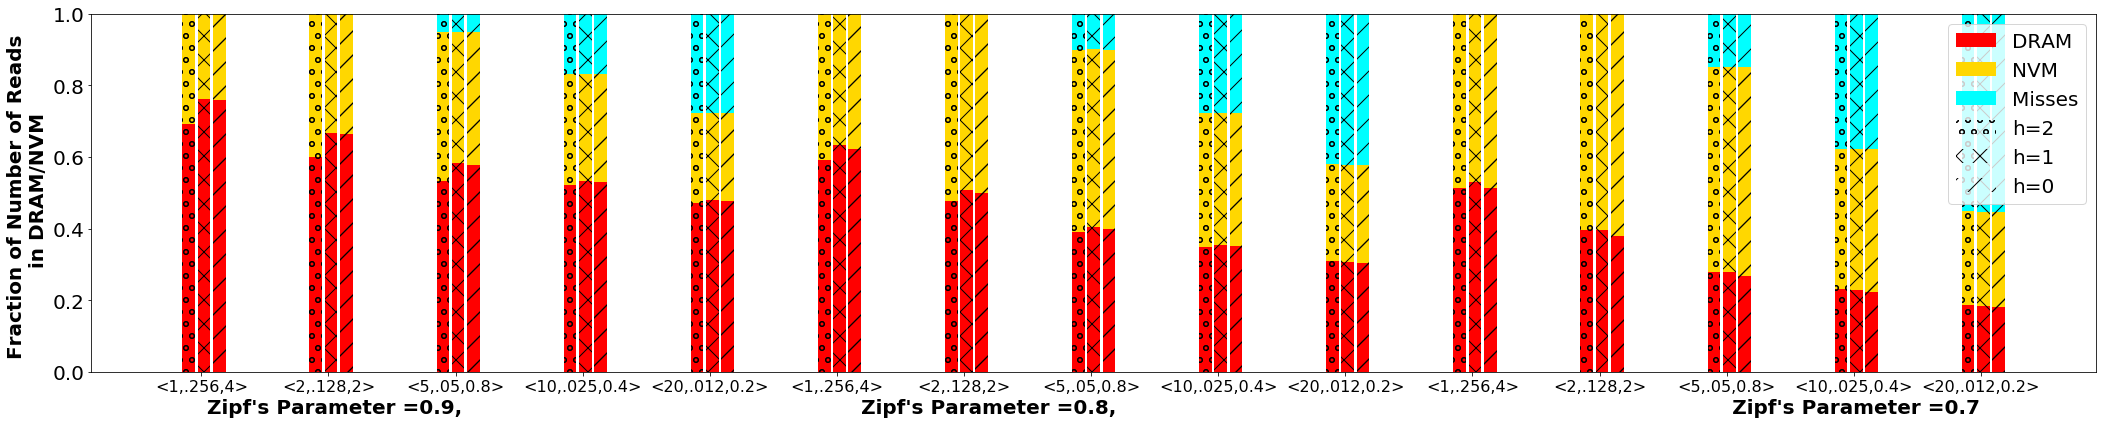

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#

n_groups = 15
rects1 = ax.bar(index+bar_width,h0_reads[:,0], bar_width, color='red', error_kw=error_config,label='DRAM')+ax.bar(index+bar_width, h0_reads[:,1], bar_width, bottom=h0_reads[:,0], color='gold', error_kw=error_config,label='NVM')+ax.bar(index+bar_width, h0_reads[:,2], bar_width,bottom=h0_reads[:,0]+h0_reads[:,1],color='aqua', error_kw=error_config,label='Misses')
rects1 = ax.bar(index+bar_width, h0_reads[:,0]+h0_reads[:,1]+h0_reads[:,2], bar_width, color='none', error_kw=error_config,label='h=2',hatch='o')
rects2 = ax.bar(index + 2.2*bar_width,h1_reads[:,0]  , bar_width, color='red', error_kw=error_config)+ax.bar(index + 2.2*bar_width, h1_reads[:,1] , bar_width,bottom=h1_reads[:,0], color='gold', error_kw=error_config)+ax.bar(index+2.2*bar_width,h1_reads[:,2] , bar_width,bottom=h1_reads[:,0]+h1_reads[:,1],color='aqua', error_kw=error_config)
rects2 = ax.bar(index + 2.2*bar_width, h1_reads[:,0]+h1_reads[:,1]+h1_reads[:,2], bar_width, color='none',hatch='x', error_kw=error_config,label='h=1')
rects3 = ax.bar(index + 3.4*bar_width, h2_reads[:,0] , bar_width, color='red',hatch='/',error_kw=error_config)+ax.bar(index + 3.4*bar_width, h2_reads[:,1] , bar_width, bottom=h2_reads[:,0], color='gold',hatch='/',error_kw=error_config)+ax.bar(index+3.4*bar_width, h2_reads[:,2], bar_width,bottom= h2_reads[:,0]+h2_reads[:,1],color='aqua', error_kw=error_config)
rects3 = ax.bar(index + 3.4*bar_width, h2_reads[:,0]+h2_reads[:,1]+h2_reads[:,2], bar_width, color='none',hatch='/',error_kw=error_config,label='h=0')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Fraction of Number of Reads \n in DRAM/NVM',fontsize=20,fontweight='bold')
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')

ax.legend(fontsize=20)
# ax.set_ylim( (pow(10,-2),pow(10,3)))
fig.tight_layout()
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('data_reads.png', bbox_inches = 'tight')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


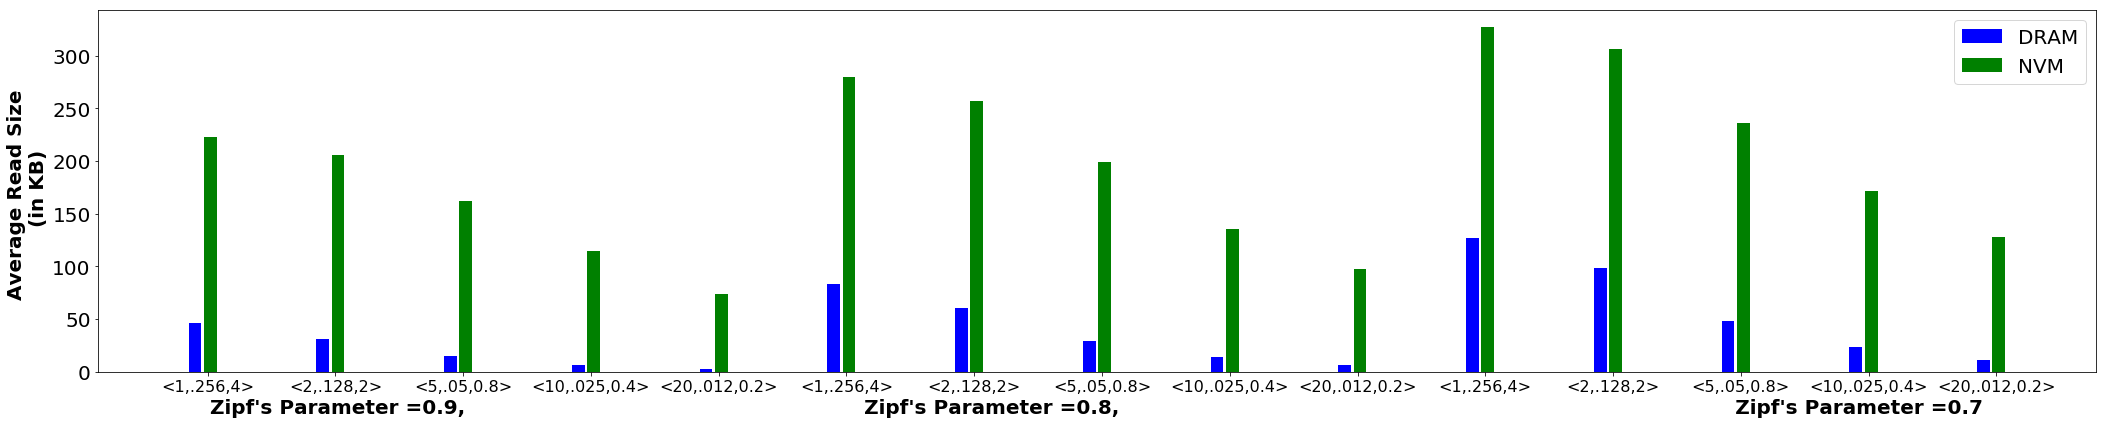

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#

n_groups = 15
rects1 = ax.bar(index+bar_width,read_dram, bar_width, color='blue', error_kw=error_config,label='DRAM')
rects2 = ax.bar(index + 2.2*bar_width,read_nvm, bar_width, color='green', error_kw=error_config,label='NVM')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Average Read Size \n (in KB)',fontsize=20,fontweight='bold')
ax.legend(fontsize=20)
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')
fig.tight_layout()
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('read_avg.png', bbox_inches = 'tight')
plt.show()